<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0"> </div>
    <div style="float: left; margin-left: 10px;"> <h1>Deep Learning From Scratch</h1>
<h1>Modular Network</h1>
        <p>Bruno Gonçalves<br/>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import watermark

%load_ext watermark
%matplotlib inline

In [2]:
%watermark -i -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 20.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: 0c0efc0550667444bda0fe2438f90df694d9769e

seaborn   : 0.11.0
matplotlib: 3.3.2
watermark : 2.1.0
json      : 2.0.9
numpy     : 1.19.2
pandas    : 1.1.3



In [3]:
plt.style.use('./d4sci.mplstyle')

## Load Dataset

In [4]:
X_train = np.load('input/X_train.npy')
X_test = np.load('input/X_test.npy')
y_train = np.load('input/y_train.npy')
y_test = np.load('input/y_test.npy')

Preprocessing

In [5]:
input_layer_size = X_train.shape[1]

X_train /= 255.
X_test /= 255.

## Initialize weights

We define the initializatino function as we'll have to call it more than once

In [6]:
def init_weights(L_in, L_out, epsilon = 0.12):
    return 2*np.random.rand(L_out, L_in+1)*epsilon - epsilon

Set the layer sizes we'll be using

In [7]:
hidden_layer_size = 50
num_labels = 10

Initialize the weights. In this case we use a array of weight matrices so that we can easily add/remove layers

In [8]:
Thetas = []
Thetas.append(init_weights(input_layer_size, hidden_layer_size))
Thetas.append(init_weights(hidden_layer_size, num_labels))

## Utility functions

One-hot encoding to define the labels

In [9]:
def one_hot(K, pos):
    y0 = np.zeros(K)
    y0[pos] = 1

    return y0

Activation function base class. Here we must provide an interface to both the activation function and its derivative

In [10]:
class Activation(object):
    def f(z):
        pass

    def df(z):
        pass

The various activation functions simply extend the base class

In [11]:
class Linear(Activation):
    def f(z):
        return z

    def df(z):
        return np.ones(z.shape)

class ReLu(Activation):
    def f(z):
        return np.where(z > 0, z, 0)

    def df(z):
        return np.where(z > 0, 1, 0)

class Sigmoid(Activation):
    def f(z):
        return 1./(1+np.exp(-z))
    
    def df(z):
        h = Sigmoid.f(z)
        return h*(1-h)

class TanH(Activation):
    def f(z):
        return np.tanh(z)

    def df(z):
        return 1-np.power(np.tanh(z), 2.0)

## Forward Propagation and Prediction

The forward and predict functions are also generalized

In [12]:
def forward(Theta, X, active):
    N = X.shape[0]

    # Add the bias column
    X_ = np.concatenate((np.ones((N, 1)), X), 1)

    # Multiply by the weights
    z = np.dot(X_, Theta.T)

    # Apply the activation function
    a = active.f(z)

    return a

The predict function now takes the entire model as input and it must loop over the various layers

In [13]:
def predict(model, X):
    h = X.copy()

    for i in range(0, len(model), 2):
        theta = model[i]
        activation = model[i+1]

        h = forward(theta, h, activation)

    return np.argmax(h, 1)

The accuracy function is just the same as before

In [14]:
def accuracy(y_, y):
    return np.mean((y_ == y.flatten()))*100.

## Back propagation

In [15]:
def backprop(model, X, y):
    M = X.shape[0]

    Thetas=[0]
    Thetas.extend(model[0::2])
    activations = [0]
    activations.extend(model[1::2])

    layers = len(Thetas)

    K = Thetas[-1].shape[0]
    J = 0

    Deltas = [0]

    for i in range(1, layers):
        Deltas.append(np.zeros(Thetas[i].shape))

    deltas = [0]*(layers+1)

    for i in range(M):
        As = [0]
        Zs = [0, 0]
        Hs = [0, X[i]]

        # Forward propagation, saving intermediate results
        As.append(np.concatenate(([1], Hs[1])))  # Input layer

        for l in range(2, layers+1):
            Zs.append(np.dot(Thetas[l-1], As[l-1]))
            Hs.append(activations[l-1].f(Zs[l]))
            As.append(np.concatenate(([1], Hs[l])))

        y0 = one_hot(K, y[i])

        # Cross entropy
        J -= np.dot(y0.T, np.log(Hs[-1]))+np.dot((1-y0).T, np.log(1-Hs[-1]))

        deltas[layers] = Hs[layers]-y0

        # Calculate the weight deltas
        for l in range(layers-1, 1, -1):
            deltas[l] = np.dot(Thetas[l].T, deltas[l+1])[1:]*activations[l].df(Zs[l])

        Deltas[2] += np.outer(deltas[3], As[2])
        Deltas[1] += np.outer(deltas[2], As[1])

    J /= M

    grads = []

    grads.append(Deltas[1]/M)
    grads.append(Deltas[2]/M)

    return [J, grads]

## Model Definition

In [16]:
model = []

model.append(Thetas[0])
model.append(Sigmoid)

model.append(Thetas[1])
model.append(Sigmoid)

## Training procedure
The same basic idea as before

In [17]:
step = 0
tol = 1e-3
J_old = 1/tol
diff = 1

acc_train = []
acc_test = []
J_val = []
steps = []

while diff > tol:
    J_train, grads = backprop(model, X_train, y_train)

    diff = abs(J_old-J_train)
    J_old = J_train
    J_val.append(J_train)

    step += 1

    for i in range(len(Thetas)):
        Thetas[i] -= .5*grads[i]
    
    if step % 10 == 0:
        pred_train = predict(model, X_train)
        pred_test = predict(model, X_test)

        J_test, grads = backprop(model, X_test, y_test)

        acc_train.append(accuracy(pred_train, y_train))
        acc_test.append(accuracy(pred_test, y_test))
        steps.append(step)
        
        print(step, J_train, J_test, acc_train[-1], acc_test[-1])
        
print(step, J_train, J_test, acc_train[-1], acc_test[-1])
print("DONE")

10 3.1221361285425395 3.110078926468578 44.7 40.6
20 2.9015457731639405 2.8941176548415863 60.06 53.7
30 2.5881785735792913 2.5964921585649945 65.44 60.8
40 2.2703446925668027 2.3024568833796293 70.96000000000001 66.0
50 2.0105686473387254 2.063300935889443 74.42 70.39999999999999
60 1.8085853148507232 1.876819341908059 77.5 72.7
70 1.6493112819485236 1.7294115551539364 79.58 75.4
80 1.5208234948328405 1.6103145342483147 81.10000000000001 76.0
90 1.41499204727328 1.5121602392098203 82.62 77.7
100 1.3261147628077687 1.4298064470524683 83.74000000000001 78.8
110 1.2501252023406468 1.3595781669609535 84.82 80.2
120 1.1841319211320804 1.2988309561594702 85.54 81.8
130 1.126089111963025 1.24566217272647 86.28 82.5
140 1.074544455616972 1.1986974020691354 87.1 83.5
150 1.0284482397310526 1.1569275974289683 87.72 84.1
160 0.9870156559865769 1.1195891747227062 88.16000000000001 84.8
170 0.9496337536928353 1.0860812695242275 88.62 85.1
180 0.9158025097946003 1.055912298289826 89.03999999999999 

## Accuracy during training

Text(0, 0.5, 'Cost function')

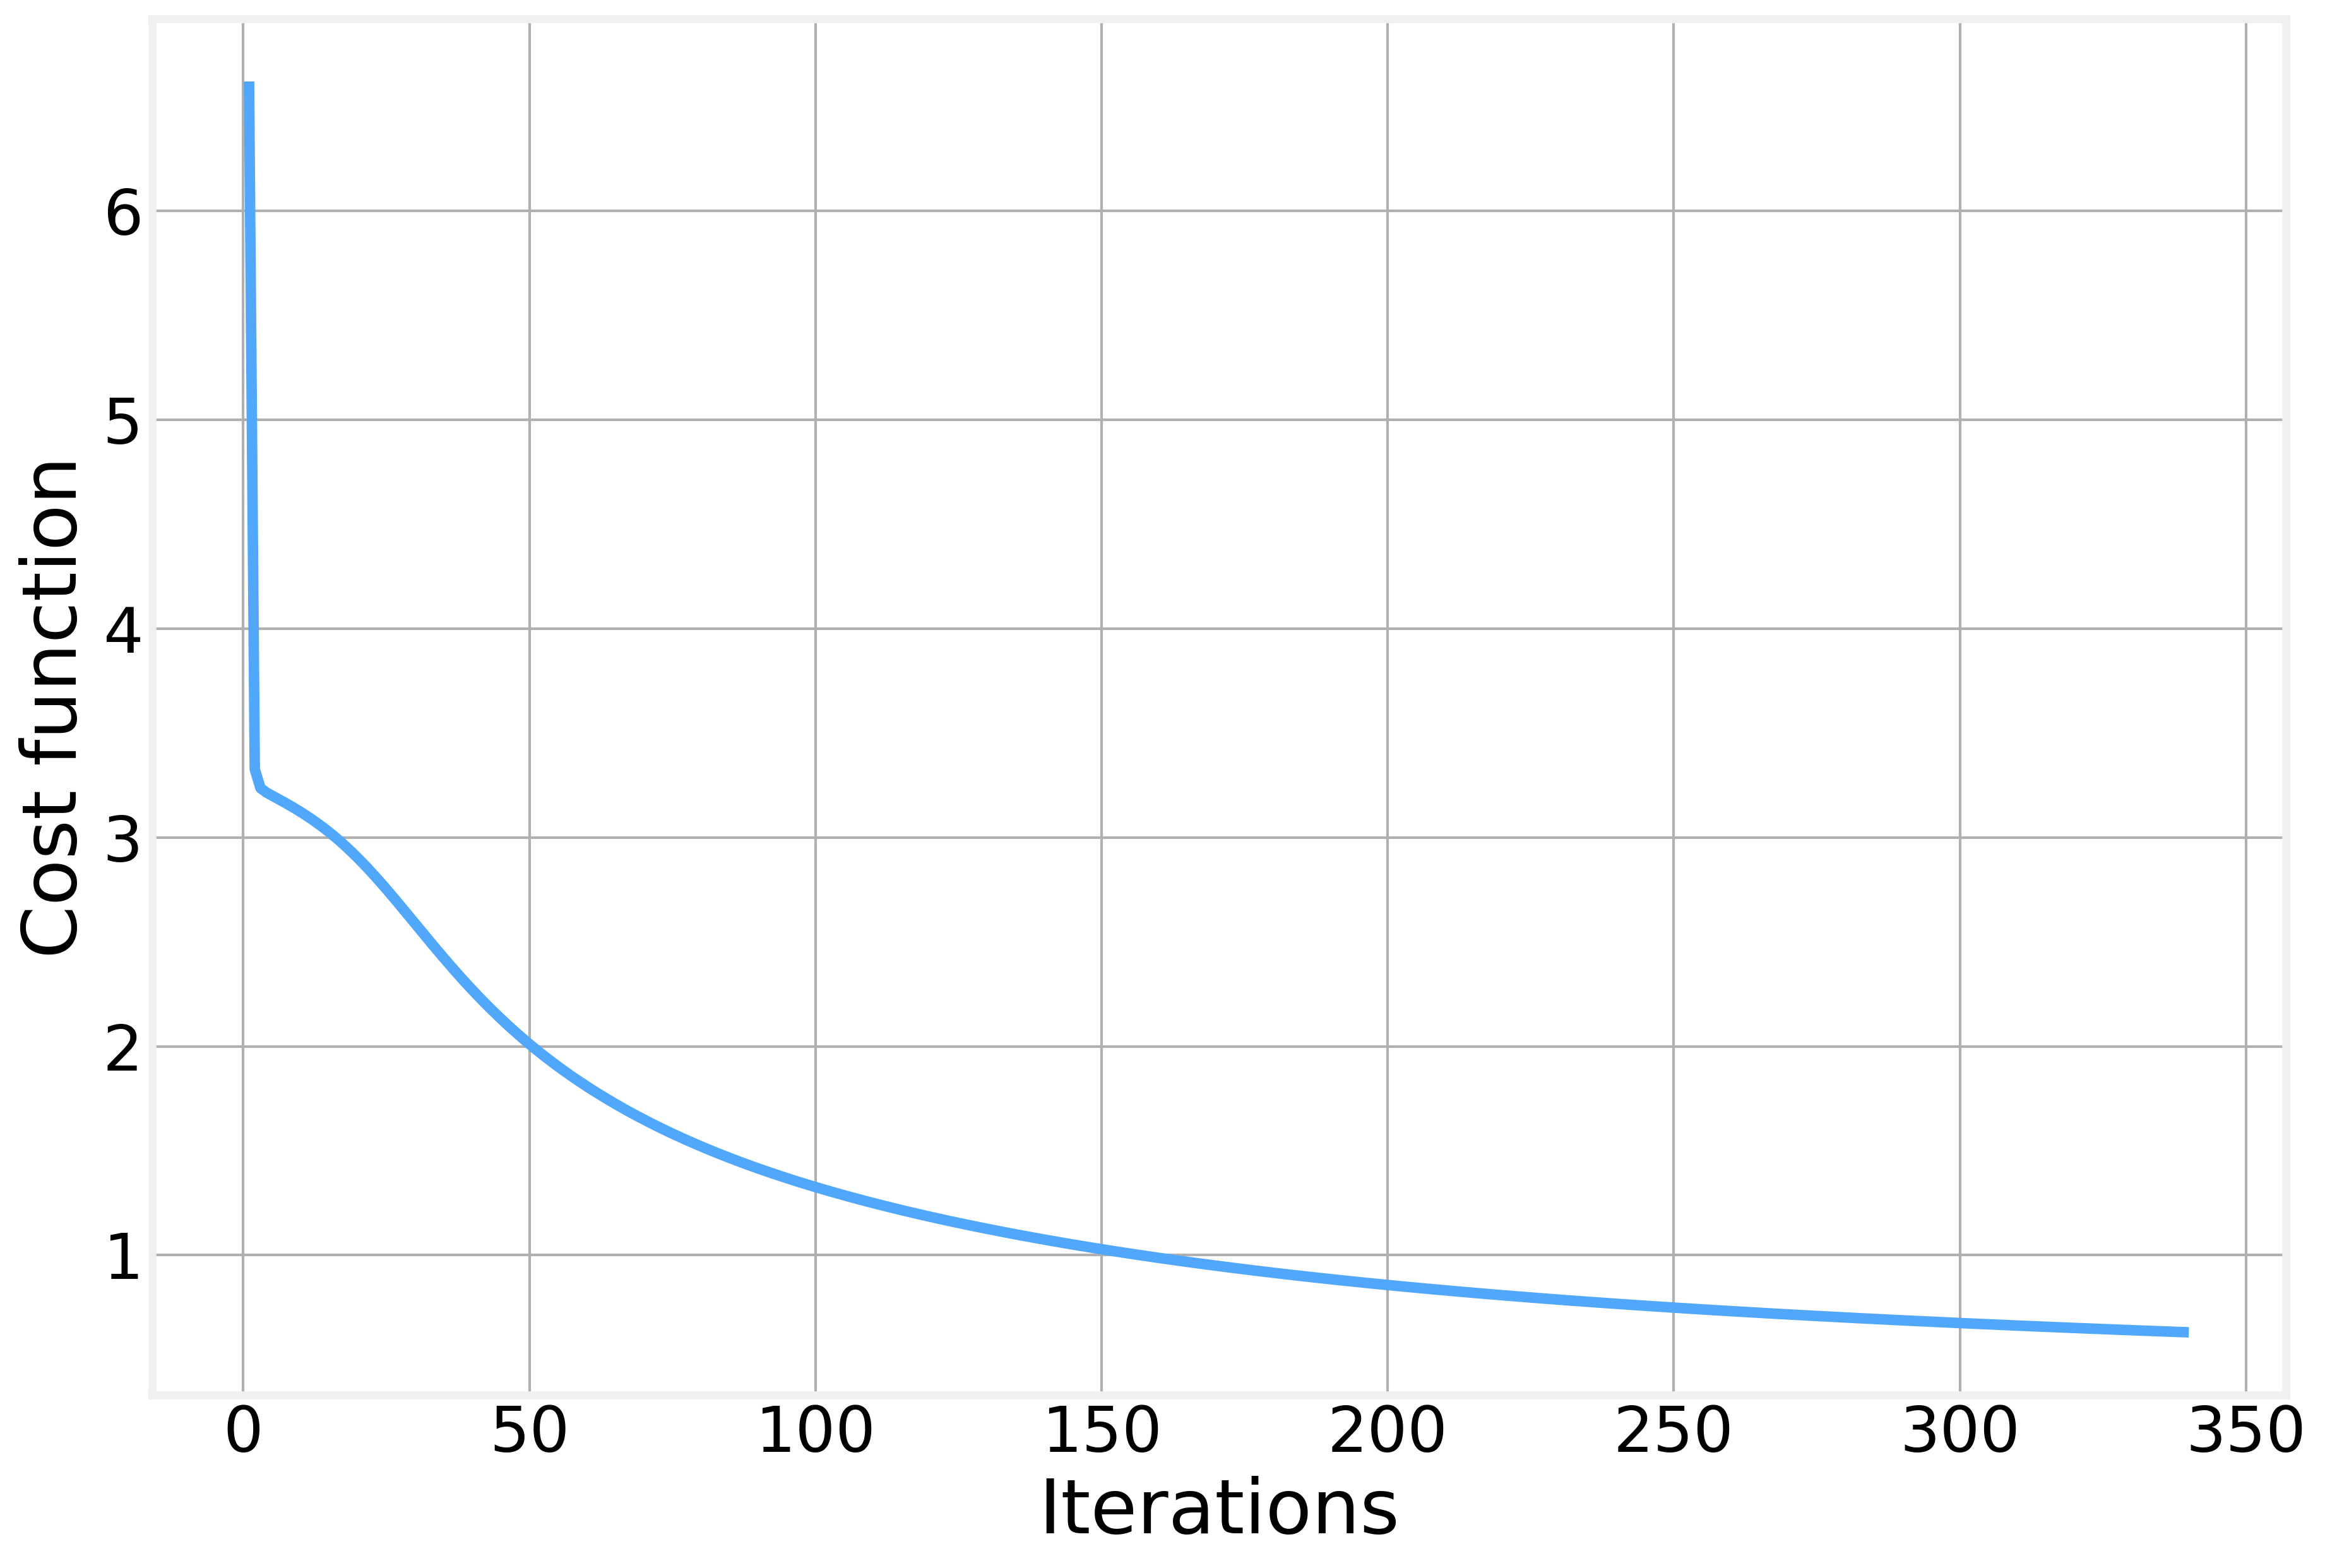

In [18]:
plt.plot(np.arange(1, len(J_val)+1), J_val)
plt.xlabel("Iterations")
plt.ylabel("Cost function")

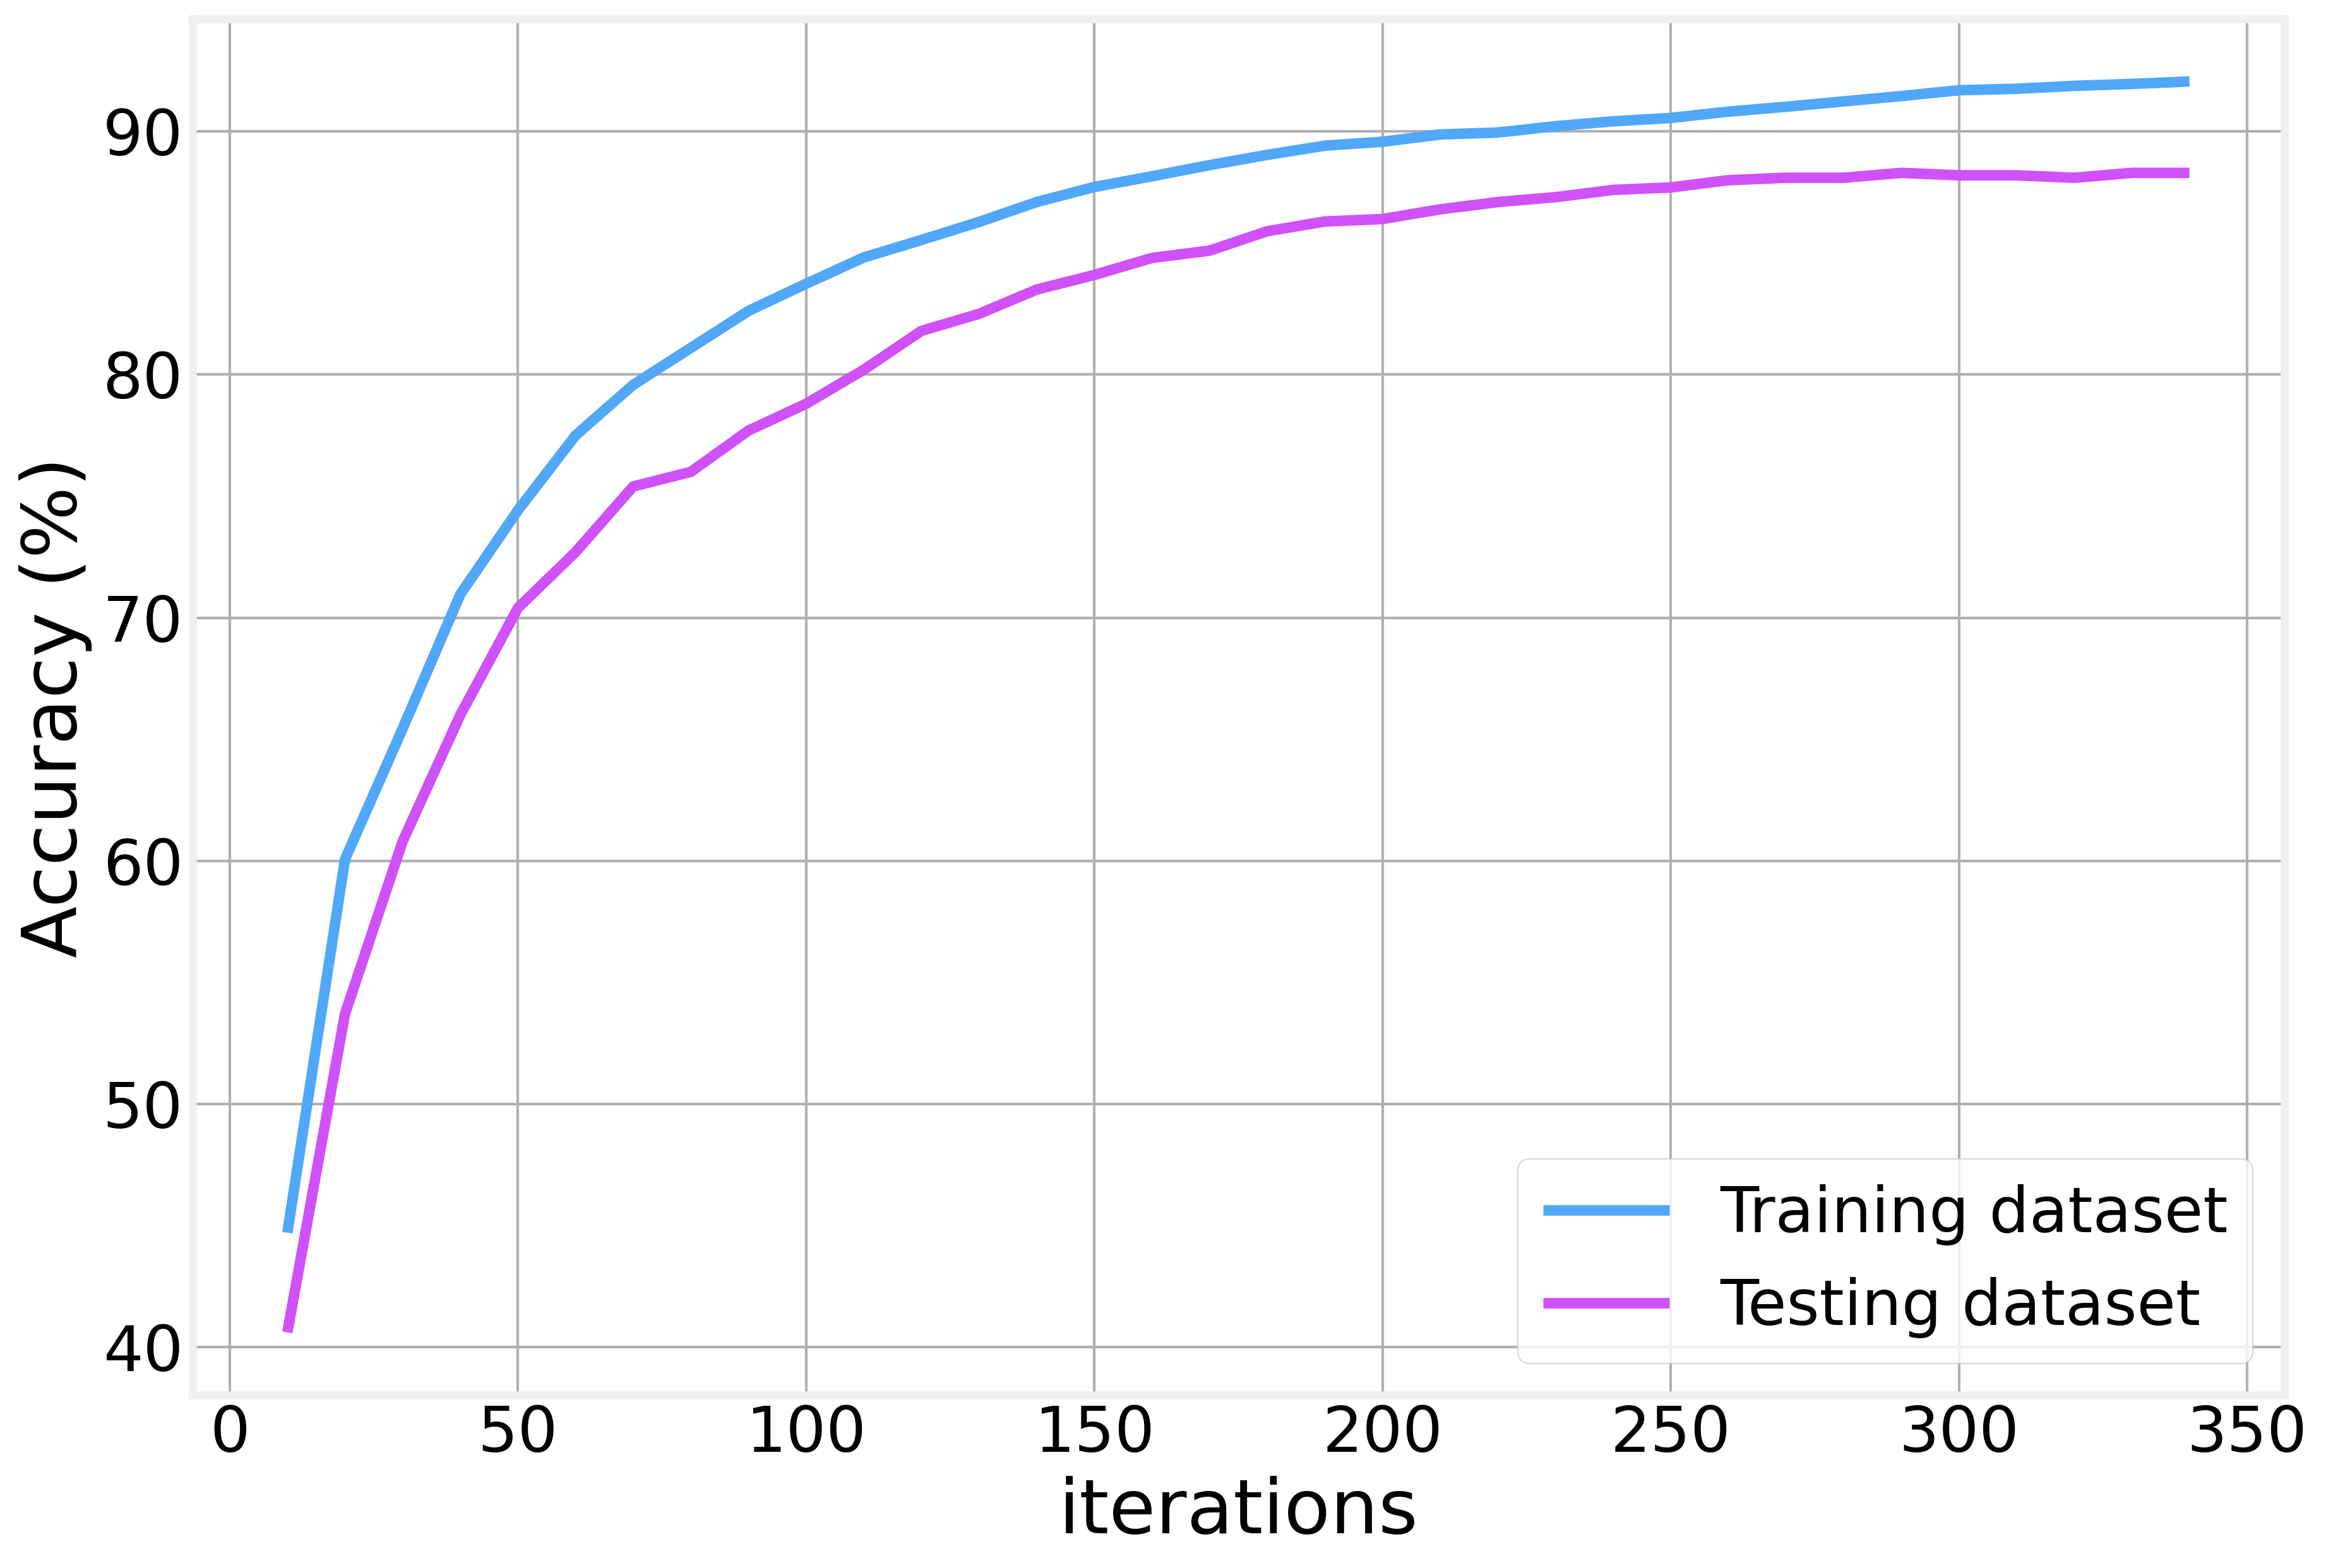

In [19]:
plt.plot(steps, acc_train, label='Training dataset')
plt.plot(steps, acc_test, label='Testing dataset')
plt.xlabel("iterations")
plt.ylabel("Accuracy (%)")
plt.legend()

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>